1. Hiểu kiến trúc autoencoder. [Optional] Hiểu và code hàm tính deconvolution, transposed convolution (visualization https://github.com/vdumoulin/conv_arithmetic...)
1. Tự tạo dataset, thực hiện denoise ảnh cifar-10
1. Giảm chiều dữ liệu cifar-10 về 2d, visualize và so sánh giữa PCA ( https://scikit-learn.org/.../sklearn.decomposition.PCA... ), neural network AE và convolutional AE.

## 1. Hiểu kiến trúc autoencoder. [Optional] Hiểu và code hàm tính deconvolution, transposed convolution (visualization https://github.com/vdumoulin/conv_arithmetic...)

In [ ]:
from tensorflow import keras
import numpy as np
from math import floor, ceil


def Conv2DTranspose(X, W, padding="valid", strides=(1, 1)):
    # Output_sỉze = (input_size - 1)*stride + kernel_size - 2*padding
    row_num = (X.shape[0] - 1) * strides[0] + W.shape[0]
    col_num = (X.shape[1] - 1) * strides[1] + W.shape[1]
    output = np.zeros([row_num, col_num])
    # Tính toán các giá trị của output 
    for i in range(0, X.shape[0]):
        i_prime = i * strides[0] # Index in output
        for j in range(0, X.shape[1]):
            j_prime = j * strides[1]
            # Insert values
            for k_row in range(W.shape[0]):
                for k_col in range(W.shape[1]):
                    output[i_prime+k_row, j_prime+k_col] += W[k_row, k_col] * X[i, j]
    # Define length of padding
    if padding == "same":
        # returns the output with the shape of (input shape)*(stride)
        p_left = floor((W.shape[0] - strides[0])/2)
        p_right = W.shape[0] - strides[0] - p_left
        p_top = floor((W.shape[1] - strides[1])/2)
        p_bottom = W.shape[1] - strides[1] - p_left
    elif padding == "valid":
        # returns the output without any padding
        p_left = 0
        p_right = 0
        p_top = 0
        p_bottom = 0
    # Add padding
    output_padded = output[p_left:output.shape[0]-p_right, p_top:output.shape[0]-p_bottom]
    return(np.array(output_padded))

In [ ]:
X = np.array([[55, 52], [57,50]])
X_reshape = X.reshape(1, 2, 2, 1)
W = np.array([[1, 2], [2, 1]])
my_output = Conv2DTranspose(X, W, padding="same", strides=(1, 1))
print("My Conv2D Transpose: \n {}".format(my_output))
print("\n")
model_Conv2D_Transpose = keras.models.Sequential()
model_Conv2D_Transpose.add(keras.layers.Conv2DTranspose(1, (2, 2), strides=(1, 1), padding='same', input_shape=(2, 2, 1)))
weights = [np.asarray([[[[1]], [[2]]], [[[2]], [[1]]]]), np.asarray([0])]
model_Conv2D_Transpose.set_weights(weights)
keras_output = model_Conv2D_Transpose.predict(X_reshape)
keras_output = keras_output.reshape(2, 2)
print("Keras Conv2D Transpose: \n {}".format(keras_output))

My Conv2D Transpose: 
 [[ 55. 162.]
 [167. 323.]]


Keras Conv2D Transpose: 
 [[ 55. 162.]
 [167. 323.]]


## 2. Tự tạo dataset, thực hiện denoise ảnh cifar-10

In [ ]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU

In [ ]:
(X_train, _), (X_test, _) = cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
X_train.shape

(50000, 32, 32, 3)

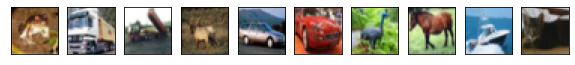

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

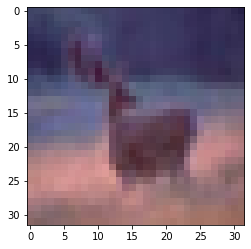

In [ ]:
X_train, X_val = train_test_split(X_train, test_size=0.2)

plt.imshow(X_train[0])

# Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.

In [ ]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train)
X_val_noisy = add_noise(X_val)
X_test_noisy  = add_noise(X_test)

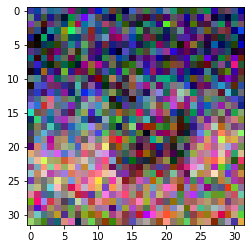

In [ ]:
plt.imshow(X_train_noisy[0])

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
from keras.optimizers import Adam

def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(32,32,3))
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    encoded = conv_block(conv_block4, 256, 3, 1) 
    
    # decoding
    deconv_block1 = deconv_block(encoded, 128, 3)
    deconv_block2 = deconv_block(deconv_block1, 64, 3)
    deconv_block3 = deconv_block(deconv_block2, 32, 3)
    # decoded = deconv_block(deconv_block3, 3, 3)
    decoded = Conv2DTranspose(filters=3,
                    kernel_size=3,strides = 2 ,activation ='sigmoid',
                    padding='same')(deconv_block3)
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    # autoencoder.summary()
    opt = Adam(learning_rate=0.01)
    autoencoder.compile(optimizer=opt, loss='binary_crossentropy')
    return autoencoder

In [ ]:
autoencoder = make_convolutional_autoencoder()

autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
re_lu_72 (ReLU)              (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_73 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
re_lu_73 (ReLU)              (None, 8, 8, 64)          0   

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 4, factor= 0.5, min_lr= 1e-6, verbose=1)

autoencoder = make_convolutional_autoencoder()
autoencoder.fit(X_train_noisy, X_train, epochs=50, batch_size=128, validation_data=(X_val_noisy, X_val),callbacks=[early_stop,rlrop])

Epoch 1/50
313/313 [==============================] - 7s 18ms/step - loss: 0.6251 - val_loss: 0.6277
Epoch 2/50
313/313 [==============================] - 4s 14ms/step - loss: 0.5839 - val_loss: 0.6027
Epoch 3/50
313/313 [==============================] - 4s 14ms/step - loss: 0.5734 - val_loss: 0.5915
Epoch 4/50
313/313 [==============================] - 4s 14ms/step - loss: 0.5713 - val_loss: 0.5851
Epoch 5/50
313/313 [==============================] - 5s 15ms/step - loss: 0.5687 - val_loss: 0.5837
Epoch 6/50
313/313 [==============================] - 5s 14ms/step - loss: 0.5665 - val_loss: 0.5889
Epoch 7/50
313/313 [==============================] - 5s 14ms/step - loss: 0.5666 - val_loss: 0.5731
Epoch 8/50
313/313 [==============================] - 5s 14ms/step - loss: 0.5661 - val_loss: 0.5708
Epoch 9/50
313/313 [==============================] - 5s 14ms/step - loss: 0.5648 - val_loss: 0.5696
Epoch 10/50
313/313 [==============================] - 4s 14ms/step - loss: 0.5644 - val_lo

In [ ]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # original
        # plt.subplot(2, 10, i+1)
        # plt.imshow(original_images[i].reshape(32, 32, 3))
        # plt.xticks([])
        # plt.yticks([])
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(32, 32, 3))
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(32, 32, 3))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
X_test_decoded = autoencoder.predict(X_test_noisy)


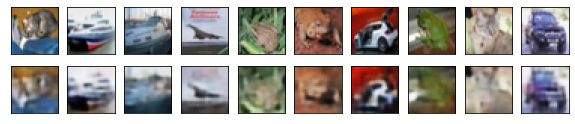

In [ ]:
show_images(X_test, X_test_decoded)

## 3. Giảm chiều dữ liệu cifar-10 về 2d, visualize và so sánh giữa PCA ( https://scikit-learn.org/.../sklearn.decomposition.PCA... ), neural network AE và convolutional AE.

In [ ]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,Activation, BatchNormalization, ReLU

In [ ]:
(X_train, _), (X_test, _) = cifar10.load_data()

In [ ]:
X_train, X_val = train_test_split(X_train, test_size=0.2)

#### Neural network AE

In [ ]:
inputs  = Input(shape=(3072,))    
enc_fc  = Dense(2048, activation='relu')(inputs)
encoded  = Dense(1024, activation='relu')(enc_fc)

In [ ]:
dec_fc  = Dense(2048, activation='relu')(encoded) 
decoded = Dense(3072, activation='sigmoid')(dec_fc) 

In [ ]:
# build the model to train
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
X_train_1 = X_train.reshape(X_train.shape[0], 3072)
X_val_1 = X_val.reshape(X_val.shape[0], 3072)
X_test_1 = X_test.reshape(X_test.shape[0], 3072)

X_train_1 = X_train_1/255.
X_test_1 = X_test_1/255.
X_val_1 = X_val_1/255.

In [ ]:
autoencoder.fit(X_train_1, X_train_1, epochs=50, batch_size=128, validation_data=(X_val_1, X_val_1))

Epoch 1/50
313/313 [==============================] - 17s 12ms/step - loss: 0.6417 - val_loss: 0.5928
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5897 - val_loss: 0.5825
Epoch 3/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5806 - val_loss: 0.5782
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5782 - val_loss: 0.5804
Epoch 5/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5760 - val_loss: 0.5743
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5736 - val_loss: 0.5722
Epoch 7/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5724 - val_loss: 0.5721
Epoch 8/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5709 - val_loss: 0.5717
Epoch 9/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5705 - val_loss: 0.5695
Epoch 10/50
313/313 [==============================] - 3s 10ms/step - loss: 0.5694 - val_l

In [ ]:
encoder_1 = Model(inputs, encoded)

In [ ]:
X_test_encoded_1 = encoder_1.predict(X_test_1)

In [ ]:
X_test_2D = X_test_encoded_1.reshape(-1,32,32)

In [ ]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(32, 32, 3))
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(32, 32),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

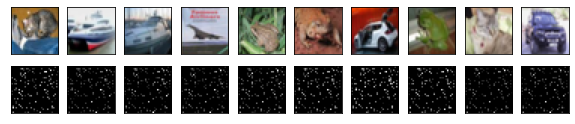

In [ ]:
show_images(X_test,X_test_2D)

#### Convolutional AE

In [ ]:
# encoding
inputs = Input(shape=(32, 32, 3))
x = Conv2D(2, 3, activation='relu', padding='same')(inputs)
encoded = Conv2D(1, 3, activation='relu', padding='same')(x)
# x = MaxPooling2D(padding='same')(x)
# x = Conv2D( 8, 3, activation='relu', padding='same')(x)
# encoded = MaxPooling2D(padding='same')(x)    

# decoding
x = Conv2DTranspose( 2, 3, activation='relu', padding='same')(encoded)
# x = UpSampling2D()(x)
# x = Conv2D( 8, 3, activation='relu', padding='same')(x)
# x = UpSampling2D()(x)
# x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'!
# x = UpSampling2D()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)    

# autoencoder
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder = make_convolutional_autoencoder()

autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 2)         56        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 1)         19        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 2)         20        
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         57        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train_2 = X_train.reshape(-1, 32, 32, 3)
X_val_2 = X_val.reshape(-1, 32, 32, 3)
X_test_2  = X_test.reshape(-1, 32, 32, 3)

X_train_2 = X_train_2/255.
X_test_2 = X_test_2/255.
X_val_2 = X_val_2/255.

In [ ]:
autoencoder.fit(X_train_2, X_train_2, epochs=50, batch_size=128, validation_data=(X_val_2, X_val_2))

Epoch 1/50
313/313 [==============================] - 4s 9ms/step - loss: 0.6771 - val_loss: 0.6106
Epoch 2/50
313/313 [==============================] - 2s 7ms/step - loss: 0.6053 - val_loss: 0.5924
Epoch 3/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5893 - val_loss: 0.5810
Epoch 4/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5790 - val_loss: 0.5743
Epoch 5/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5728 - val_loss: 0.5685
Epoch 6/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5675 - val_loss: 0.5668
Epoch 7/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5666 - val_loss: 0.5663
Epoch 8/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5665 - val_loss: 0.5659
Epoch 9/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5661 - val_loss: 0.5658
Epoch 10/50
313/313 [==============================] - 2s 7ms/step - loss: 0.5654 - val_loss: 0.5655

In [ ]:
encoder_2 = Model(inputs, encoded)

In [ ]:
X_test_encoded_2 = encoder_2.predict(X_test_2)

In [ ]:
X_test_2D = X_test_encoded_2.reshape(-1,32,32)

In [ ]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(32, 32, 3))
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(32, 32),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

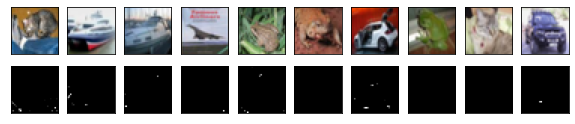

In [ ]:
show_images(X_test,X_test_2D)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=1024)
pca.fit(X_train.reshape((len(X_train),32*32*3)))

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_PCA = pca.transform(X_test.reshape((len(X_test),32*32*3)))

In [ ]:
X_PCA = X_PCA.reshape(X_PCA.shape[0],32,32)

In [ ]:
X_PCA.shape

(10000, 32, 32)

In [ ]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(32, 32, 3))
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(32, 32),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

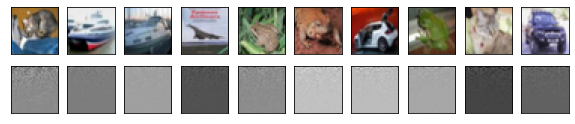

In [ ]:
show_images(X_test,X_PCA)